In [1]:
import torch
import os
import sys
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import pandas as pd

os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'
sys.path.append(os.path.abspath(os.path.join(os.path.dirname('examples'), '..')))

from tedeous.data import Domain, Conditions, Equation
from tedeous.model import Model
from tedeous.models import mat_model, Fourier_embedding
from tedeous.callbacks import plot, early_stopping, adaptive_lambda
from tedeous.optimizers.optimizer import Optimizer
from tedeous.device import solver_device
from tedeous.eval import integration

In [4]:
solver_device('cuda')

a = 1. / torch.pi**2

def u(grid):
  return torch.sin(torch.pi * grid[:,0])*torch.exp(-grid[:,1])

def u_net(net, x):
    net = net.to('cpu')
    x = x.to('cpu')
    return net(x).detach()

def l2_norm(net, x):
    x = x.to('cpu')
    net = net.to('cpu')
    predict = net(x).detach().cpu().reshape(-1)
    exact = u(x).detach().cpu().reshape(-1)
    l2_norm = torch.sqrt(sum((predict-exact)**2))
    return l2_norm.detach().cpu().numpy()

def experiment(N):
    exp_dict_list = []

    domain = Domain()

    domain.variable('x', [-1, 1], N, dtype='float32')
    domain.variable('t', [0, 1], N, dtype='float32')

    boundaries = Conditions()

    boundaries.dirichlet({'x': -1, 't': [0, 1]}, value=u)
    boundaries.dirichlet({'x': 1, 't': [0, 1]}, value=u)
    boundaries.dirichlet({'x': [-1, 1], 't': 0}, value=u)

    equation = Equation()

    heat = {
        '+a*d2u/dx2':
            {
            'coeff': a,
            'term': [0, 0],
            'pow': 1,
            },

        '-du/dt':
            {
            'coeff': -1,
            'term': [1],
            'pow': 1,
            }
    }

    equation.add(heat)

    net = torch.nn.Sequential(
            torch.nn.Linear(2, 50),
            torch.nn.Tanh(),
            torch.nn.Linear(50, 50),
            torch.nn.Tanh(),
            torch.nn.Linear(50, 50),
            torch.nn.Tanh(),
            torch.nn.Linear(50, 1)
        )

    model = Model(net, domain, equation, boundaries)

    model.compile('autograd', lambda_operator=1, lambda_bound=1)
    
    cb_es = early_stopping.EarlyStopping(eps=1e-6, randomize_parameter=1e-6)

    optimizer = Optimizer('Adam', {'lr': 1e-4})

    model.train(optimizer, 5e5, save_model=False, callbacks=[cb_es])

    l2_loss = model.solution_cls.evaluate()[0].detach().cpu().numpy()

    lu_f = model.solution_cls.operator.operator_compute()

    grid = model.solution_cls.grid

    lu_f, grid1 = integration(lu_f, grid)

    lu_f, _ = integration(lu_f, grid1)

    exp_dict_list.append({'grid_res': N,
                          'l2_loss': l2_loss,
                          "lu_f": lu_f.item(),
                          'l2_norm': l2_norm(net, grid),
                          'type':'heat'})

    print('grid_res=', N)
    print('l2_norm = ', l2_norm(net, grid))
    print('lu_f = ', lu_f.item())

    fig = plt.figure(figsize=(15, 8))
    ax1 = fig.add_subplot(1, 1, 1, projection='3d')
    ax1.plot_trisurf(grid[:, 0].detach().cpu().numpy(),
                     grid[:, 1].detach().cpu().numpy(),
                     net(grid.cpu()).detach().cpu().numpy().reshape(-1),
                        cmap=cm.jet, linewidth=0.2, alpha=1)
    ax1.plot_trisurf(grid[:, 0].detach().cpu().numpy(),
                    grid[:, 1].detach().cpu().numpy(),
                    u(grid).detach().cpu().numpy().reshape(-1),
                    linewidth=0.2, alpha=1)
    ax1.set_xlabel("x1")
    ax1.set_ylabel("x2")
    plt.legend(loc='upper right')
    plt.show()

    return exp_dict_list

def experiment_PSO(N):
    exp_dict_list = []

    domain = Domain()

    domain.variable('x', [-1, 1], N, dtype='float32')
    domain.variable('t', [0, 1], N, dtype='float32')

    boundaries = Conditions()

    boundaries.dirichlet({'x': -1, 't': [0, 1]}, value=u)
    boundaries.dirichlet({'x': 1, 't': [0, 1]}, value=u)
    boundaries.dirichlet({'x': [-1, 1], 't': 0}, value=u)

    equation = Equation()

    heat = {
        '+a*d2u/dx2':
            {
            'coeff': a,
            'term': [0, 0],
            'pow': 1,
            },

        '-du/dt':
            {
            'coeff': -1,
            'term': [1],
            'pow': 1,
            }
    }

    equation.add(heat)

    net = torch.nn.Sequential(
            torch.nn.Linear(2, 50),
            torch.nn.Tanh(),
            torch.nn.Linear(50, 50),
            torch.nn.Tanh(),
            torch.nn.Linear(50, 50),
            torch.nn.Tanh(),
            torch.nn.Linear(50, 1)
        )

    model = Model(net, domain, equation, boundaries)

    model.compile('autograd', lambda_operator=1, lambda_bound=1)
    
    cb_es = early_stopping.EarlyStopping(eps=1e-6, randomize_parameter=1e-6)

    optimizer = Optimizer('Adam', {'lr': 1e-3})

    model.train(optimizer, 5e5, save_model=False, callbacks=[cb_es])

    grid = model.solution_cls.grid

    l2_pinn = l2_norm(net, grid)
    print('l2_norm = ', l2_pinn)
    net = net.to('cuda')

    ########

    cb_es = early_stopping.EarlyStopping(eps=1e-9, randomize_parameter=1e-6, info_string_every=1000)

    optimizer = Optimizer('PSO', {'pop_size': 50, #30
                                  'b': 0.4, #0.5
                                  'c2': 0.5, #0.05
                                  'c1': 0.5, 
                                  'variance': 5e-2,
                                  'lr': 1e-4})

    model.train(optimizer, 20000, save_model=False, callbacks=[cb_es])

    l2_loss = model.solution_cls.evaluate()[0].detach().cpu().numpy()

    lu_f = model.solution_cls.operator.operator_compute()

    grid = model.solution_cls.grid

    lu_f, grid1 = integration(lu_f, grid)

    lu_f, _ = integration(lu_f, grid1)

    exp_dict_list.append({'grid_res': N,
                          'l2_loss': l2_loss,
                          'l2_PSO': l2_norm(net, grid),
                          'l2_pinn': l2_pinn,
                          "lu_f": lu_f.item(),
                          'type':'heat'})

    print('grid_res=', N)
    print('l2_norm = ', l2_norm(net, grid))
    print('lu_f = ', lu_f.item())

    fig = plt.figure(figsize=(15, 8))
    ax1 = fig.add_subplot(1, 1, 1, projection='3d')
    ax1.plot_trisurf(grid[:, 0].detach().cpu().numpy(),
                     grid[:, 1].detach().cpu().numpy(),
                     net(grid.cpu()).detach().cpu().numpy().reshape(-1),
                        cmap=cm.jet, linewidth=0.2, alpha=1)
    ax1.plot_trisurf(grid[:, 0].detach().cpu().numpy(),
                    grid[:, 1].detach().cpu().numpy(),
                    u(grid).detach().cpu().numpy().reshape(-1),
                    linewidth=0.2, alpha=1)
    ax1.set_xlabel("x1")
    ax1.set_ylabel("x2")
    plt.legend(loc='upper right')
    plt.show()

    return exp_dict_list

def experiment_mat(N):
    solver_device('cuda')

    exp_dict_list = []

    x0 = -1
    xmax = 1

    domain = Domain()

    domain.variable('x', [x0, xmax], N, dtype='float32')

    boundaries = Conditions()

    boundaries.dirichlet({'x': x0}, value=u)
    boundaries.dirichlet({'x': xmax}, value=u)

    grid = domain.variable_dict['x']
    # equation: d2u/dx2 = -16*pi^2*sin(4*pi*x)

    equation = Equation()

    poisson = {
        '-d2u/dx2':
            {
            'coeff': -1,
            'term': [0, 0],
            'pow': 1,
            },

        'f(x)':
            {
            'coeff': u_xx(grid),
            'term': [None],
            'pow': 0,
            }
    }

    equation.add(poisson)

    net = torch.nn.Sequential(
            torch.nn.Linear(1, 50),
            torch.nn.Tanh(),
            torch.nn.Linear(50, 50),
            torch.nn.Tanh(),
            torch.nn.Linear(50, 50),
            torch.nn.Tanh(),
            torch.nn.Linear(50, 1)
        )

    model = Model(net, domain, equation, boundaries)

    model.compile('autograd', lambda_operator=1, lambda_bound=1)

    cb_es = early_stopping.EarlyStopping(eps=1e-9, randomize_parameter=1e-6)

    optimizer = Optimizer('Adam', {'lr': 1e-4})

    model.train(optimizer, 5e5, save_model=False, callbacks=[cb_es])

    grid = torch.linspace(-1, 1, N+1).reshape(-1,1)

    l2_pinn = l2_norm(net, grid)
    print('l2_norm = ', l2_pinn)
    net = net.to('cuda')


    ########
    solver_device('cpu')

    net = net(grid).reshape(1, N+1).detach().cpu()

    domain = Domain()

    domain.variable('x', [x0, xmax], N, dtype='float32')

    boundaries = Conditions()

    boundaries.dirichlet({'x': x0}, value=u)
    boundaries.dirichlet({'x': xmax}, value=u)

    grid = domain.variable_dict['x']
    # equation: d2u/dx2 = -16*pi^2*sin(4*pi*x)

    equation = Equation()

    poisson = {
        '-d2u/dx2':
            {
            'coeff': -1,
            'term': [0, 0],
            'pow': 1,
            },

        'f(x)':
            {
            'coeff': u_xx(grid),
            'term': [None],
            'pow': 0,
            }
    }

    equation.add(poisson)

    model = Model(net, domain, equation, boundaries)

    model.compile('mat', lambda_operator=1, lambda_bound=1, derivative_points=3)

    cb_es = early_stopping.EarlyStopping(eps=1e-9, randomize_parameter=1e-6)

    optimizer = Optimizer('LBFGS', {'lr': 1e-2})

    model.train(optimizer, 5e5, save_model=False, callbacks=[cb_es])

    l2_loss = model.solution_cls.evaluate()[0].detach().cpu().numpy()

    grid = domain.build('mat')

    exp_dict_list.append({'grid_res': N, 'l2_loss': l2_loss, 'l2_mat': l2_norm_mat(net, grid), 'l2_pinn': l2_pinn, 'type':'Poisson_mat'})

    print('grid_res=', N)
    print('l2_norm = ', l2_norm_mat(net, grid))

    plt.plot(grid.detach().cpu().numpy().reshape(-1), u(grid).detach().cpu().numpy().reshape(-1), label='Exact')
    plt.plot(grid.detach().cpu().numpy().reshape(-1), net.detach().cpu().numpy().reshape(-1), '--', label='Predicted')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend(loc='upper right')
    plt.show()

    return exp_dict_list

def experiment_neur(N):
    exp_dict_list = []

    x0 = -1
    xmax = 1

    domain = Domain()

    domain.variable('x', [x0, xmax], 300, dtype='float32')

    boundaries = Conditions()

    boundaries.dirichlet({'x': x0}, value=u)
    boundaries.dirichlet({'x': xmax}, value=u)

    grid = domain.variable_dict['x'].reshape(-1,1)

    # equation: d2u/dx2 = -16*pi^2*sin(4*pi*x)

    equation = Equation()

    poisson = {
        '-d2u/dx2':
            {
            'coeff': -1,
            'term': [0, 0],
            'pow': 1,
            },

        'f(x)':
            {
            'coeff': u_xx(grid),
            'term': [None],
            'pow': 0,
            }
    }

    equation.add(poisson)

    net = torch.nn.Sequential(
            torch.nn.Linear(1, N),
            torch.nn.Tanh(),
            torch.nn.Linear(N, N),
            torch.nn.Tanh(),
            torch.nn.Linear(N, N),
            torch.nn.Tanh(),
            torch.nn.Linear(N, 1)
        )

    model = Model(net, domain, equation, boundaries)

    model.compile('autograd', lambda_operator=1, lambda_bound=1)

    img_dir = os.path.join(os.path.dirname('examples'), 'poisson_img')
    
    cb_es = early_stopping.EarlyStopping(eps=1e-9, randomize_parameter=1e-6)

    cb_plots = plot.Plots(save_every=None, print_every=None, img_dir=img_dir)

    optimizer = Optimizer('Adam', {'lr': 1e-4}, gamma=0.9, decay_every=1000)

    model.train(optimizer, 5e5, save_model=False, callbacks=[cb_plots, cb_es])

    l2_loss = model.solution_cls.evaluate()[0].detach().cpu().numpy()

    grid_error = torch.linspace(-1, 1, 10001).reshape(-1,1)

    exp_dict_list.append({'NN_res': N, 'l2_loss': l2_loss, 'l2_norm': l2_norm(net, grid_error), 'c2_norm': c2_norm(net, grid_error), 'type':'Poisson'})

    print('grid_res=', N)
    print('c2_norm = ', c2_norm(net, grid_error))
    print('l2_norm = ', l2_norm(net, grid_error))

    plt.plot(grid.detach().cpu().numpy(), u(grid).detach().cpu().numpy(), label='Exact')
    plt.plot(grid.detach().cpu().numpy(), net(grid.cpu()).detach().cpu().numpy(), '--', label='Predicted')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend(loc='upper right')
    plt.show()

    return exp_dict_list

def experiment_lam(N):
    exp_dict_list = []

    x0 = -1
    xmax = 1

    domain = Domain()

    domain.variable('x', [x0, xmax], N, dtype='float32')

    boundaries = Conditions()

    boundaries.dirichlet({'x': x0}, value=u)
    boundaries.dirichlet({'x': xmax}, value=u)

    grid = domain.variable_dict['x'].reshape(-1,1)

    # equation: d2u/dx2 = -16*pi^2*sin(4*pi*x)

    equation = Equation()

    poisson = {
        '-d2u/dx2':
            {
            'coeff': -1,
            'term': [0, 0],
            'pow': 1,
            },

        'f(x)':
            {
            'coeff': u_xx(grid),
            'term': [None],
            'pow': 0,
            }
    }

    equation.add(poisson)

    net = torch.nn.Sequential(
            torch.nn.Linear(1, 50),
            torch.nn.Tanh(),
            torch.nn.Linear(50, 50),
            torch.nn.Tanh(),
            torch.nn.Linear(50, 50),
            torch.nn.Tanh(),
            torch.nn.Linear(50, 1)
        )

    model = Model(net, domain, equation, boundaries)

    model.compile('autograd', lambda_operator=1, lambda_bound=1)

    img_dir = os.path.join(os.path.dirname('examples'), 'poisson_img')

    cb_lam = adaptive_lambda.AdaptiveLambda()
    
    cb_es = early_stopping.EarlyStopping(eps=1e-9, randomize_parameter=1e-6, normalized_loss=True)

    optimizer = Optimizer('Adam', {'lr': 1e-4}, gamma=0.9, decay_every=1000)

    model.train(optimizer, 5e5, save_model=False, callbacks=[cb_es, cb_lam])

    l2_loss = model.solution_cls.evaluate()[0].detach().cpu().numpy()

    grid_error = torch.linspace(-1, 1, 10001).reshape(-1,1)

    exp_dict_list.append({'grid_res': N, 'l2_loss': l2_loss, 'l2_norm': l2_norm(net, grid_error), 'c2_norm': c2_norm(net, grid_error), 'type':'Poisson'})

    print('grid_res=', N)
    print('c2_norm = ', c2_norm(net, grid_error))
    print('l2_norm = ', l2_norm(net, grid_error))

    plt.plot(grid.detach().cpu().numpy(), u(grid).detach().cpu().numpy(), label='Exact')
    plt.plot(grid.detach().cpu().numpy(), net(grid.cpu()).detach().cpu().numpy(), '--', label='Predicted')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend(loc='upper right')
    plt.show()

    return exp_dict_list

def experiment_fourier(N):
    exp_dict_list = []

    x0 = -1
    xmax = 1

    domain = Domain()

    domain.variable('x', [x0, xmax], N, dtype='float32')

    boundaries = Conditions()

    boundaries.dirichlet({'x': x0}, value=u)
    boundaries.dirichlet({'x': xmax}, value=u)

    grid = domain.variable_dict['x'].reshape(-1,1)

    # equation: d2u/dx2 = -16*pi^2*sin(4*pi*x)

    equation = Equation()

    poisson = {
        '-d2u/dx2':
            {
            'coeff': -1,
            'term': [0, 0],
            'pow': 1,
            },

        'f(x)':
            {
            'coeff': u_xx(grid),
            'term': [None],
            'pow': 0,
            }
    }

    equation.add(poisson)

    FFL = Fourier_embedding(L=[2], M=[1])

    out = FFL.out_features

    net = torch.nn.Sequential(
            FFL,
            torch.nn.Linear(out, 50),
            torch.nn.Tanh(),
            torch.nn.Linear(50, 50),
            torch.nn.Tanh(),
            torch.nn.Linear(50, 50),
            torch.nn.Tanh(),
            torch.nn.Linear(50, 1)
        )

    model = Model(net, domain, equation, boundaries)

    model.compile('autograd', lambda_operator=1, lambda_bound=1)
    
    cb_es = early_stopping.EarlyStopping(eps=1e-9, randomize_parameter=1e-6)

    optimizer = Optimizer('Adam', {'lr': 1e-3}, gamma=0.9, decay_every=1000)

    model.train(optimizer, 5e5, save_model=False, callbacks=[cb_es])

    l2_loss = model.solution_cls.evaluate()[0].detach().cpu().numpy()

    grid_error = torch.linspace(-1, 1, 10001).reshape(-1,1)

    exp_dict_list.append({'grid_res': N, 'l2_loss': l2_loss, 'l2_norm': l2_norm(net, grid_error), 'type':'Poisson'})

    print('grid_res=', N)
    # print('c2_norm = ', c2_norm(net, grid_error))
    print('l2_norm = ', l2_norm(net, grid_error))

    plt.plot(grid.detach().cpu().numpy(), u(grid).detach().cpu().numpy(), label='Exact')
    plt.plot(grid.detach().cpu().numpy(), net(grid).detach().cpu().numpy(), '--', label='Predicted')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend(loc='upper right')
    plt.show()

    return exp_dict_list


CUDA is available and used.


In [5]:

# Создайте список для каждой части
part1 = np.arange(2, 10, 3)
part2 = np.arange(10, 100, 20)
part3 = np.arange(100, 1000, 300)
part4 = np.arange(1000, 11000, 3000)
part5 = np.array([100000])

neurons = np.array([2, 8, 16, 32, 64, 128, 216, 512])

grid_n = np.concatenate([part1, part2])

[2024-03-14 11:46:05.544670] initial (min) loss is 0.00802866742014885
[2024-03-14 11:48:07.408827] No improvement in 1000 steps
[2024-03-14 11:48:07.408827] Step = 15187 loss = 0.000000 normalized loss line= -0.122585x+9.925848. There was 1 stop dings already.
[2024-03-14 11:48:15.332163] No improvement in 1000 steps
[2024-03-14 11:48:15.332163] Step = 16187 loss = 0.000000 normalized loss line= -809.574423x+80017.428178. There was 2 stop dings already.
[2024-03-14 11:48:27.436041] No improvement in 1000 steps
[2024-03-14 11:48:27.436041] Step = 17792 loss = 0.000000 normalized loss line= -9.612830x+943.451465. There was 3 stop dings already.
[2024-03-14 11:48:35.008960] No improvement in 1000 steps
[2024-03-14 11:48:35.008960] Step = 18792 loss = 0.000000 normalized loss line= -0.006544x+2.148949. There was 4 stop dings already.
[2024-03-14 11:48:42.518968] No improvement in 1000 steps
[2024-03-14 11:48:42.518968] Step = 19792 loss = 0.000000 normalized loss line= -0.002136x+1.360242

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[2024-03-14 12:42:18.160718] No improvement in 1000 steps
[2024-03-14 12:42:18.160718] Step = 10240 loss = 0.000000 normalized loss line= 0.000002x+1.000341. There was 5 stop dings already.
grid_res= 2
l2_norm =  5.274636e-06
lu_f =  1.7215103534204147e-26


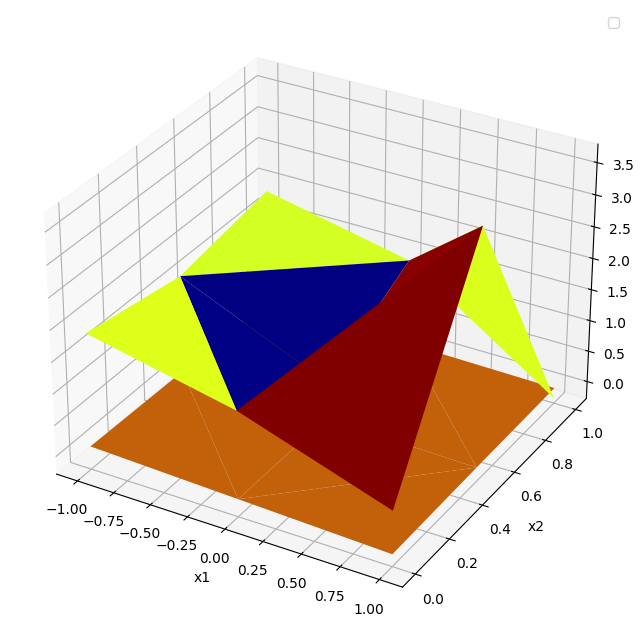

[2024-03-14 12:42:18.450474] initial (min) loss is 0.14023548364639282
[2024-03-14 12:46:50.940295] No improvement in 1000 steps
[2024-03-14 12:46:50.940295] Step = 36398 loss = 0.000001 normalized loss line= 0.547067x+-6.840877. There was 1 stop dings already.
[2024-03-14 12:47:05.696858] No improvement in 1000 steps
[2024-03-14 12:47:05.696858] Step = 38368 loss = 0.000000 normalized loss line= 0.658806x+32.420271. There was 2 stop dings already.
[2024-03-14 12:47:25.738956] No improvement in 1000 steps
[2024-03-14 12:47:25.738956] Step = 41025 loss = 0.000000 normalized loss line= 0.399324x+3.278596. There was 3 stop dings already.
[2024-03-14 12:47:54.063147] No improvement in 1000 steps
[2024-03-14 12:47:54.063147] Step = 44772 loss = 0.000092 normalized loss line= 0.001846x+0.118886. There was 4 stop dings already.
[2024-03-14 12:48:02.129540] No improvement in 1000 steps
[2024-03-14 12:48:02.129540] Step = 45829 loss = 0.000012 normalized loss line= 0.025976x+-0.526715. There wa

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


grid_res= 5
l2_norm =  0.1338835
lu_f =  1.6319185577729606e-15


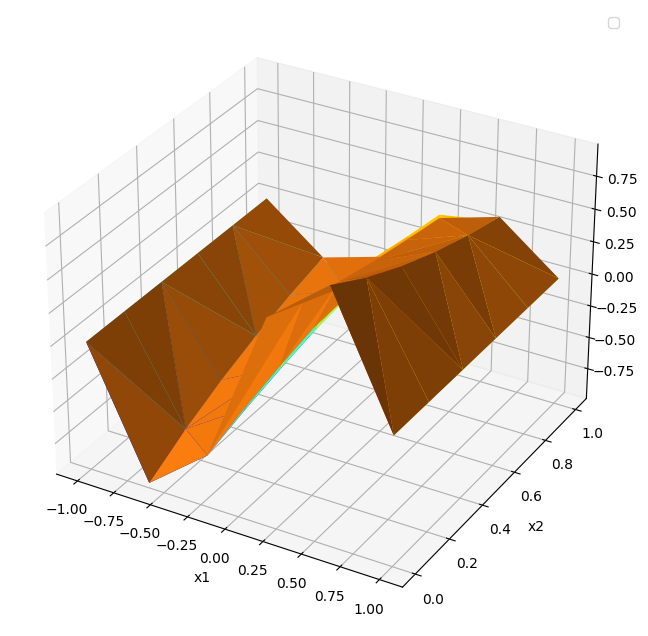

[2024-03-14 14:35:21.089187] initial (min) loss is 0.18000245094299316
[2024-03-14 14:42:21.722889] No improvement in 1000 steps
[2024-03-14 14:42:21.722889] Step = 56157 loss = 0.000003 normalized loss line= -0.088656x+7.032192. There was 1 stop dings already.
[2024-03-14 14:42:47.003915] No improvement in 1000 steps
[2024-03-14 14:42:47.003915] Step = 59530 loss = 0.000001 normalized loss line= 0.209085x+-0.987940. There was 2 stop dings already.
[2024-03-14 14:43:17.972858] No improvement in 1000 steps
[2024-03-14 14:43:17.972858] Step = 63665 loss = 0.000002 normalized loss line= -0.084864x+6.289273. There was 3 stop dings already.
[2024-03-14 14:43:39.168117] No improvement in 1000 steps
[2024-03-14 14:43:39.168117] Step = 66497 loss = 0.000030 normalized loss line= 0.002732x+0.051928. There was 4 stop dings already.
[2024-03-14 14:43:55.649331] No improvement in 1000 steps
[2024-03-14 14:43:55.649331] Step = 68700 loss = 0.000000 normalized loss line= -3.560044x+263.641847. There

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


grid_res= 8
l2_norm =  0.009289577
lu_f =  3.0660157470882316e-16


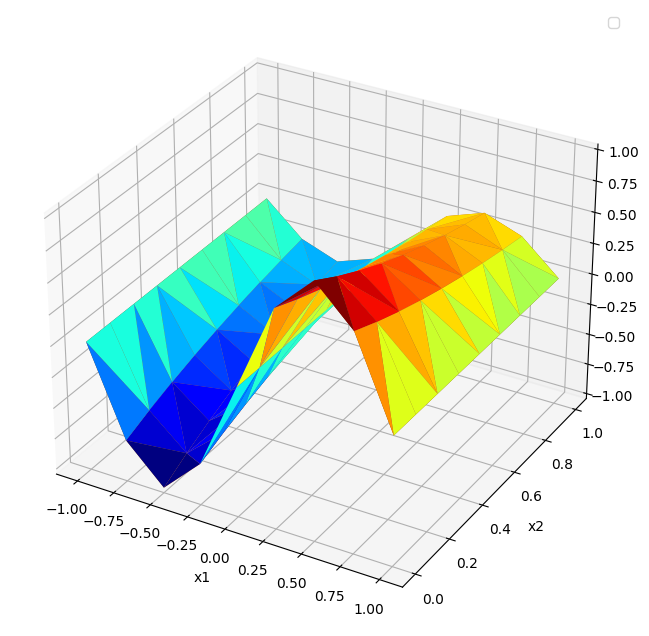

[2024-03-14 16:30:11.240353] initial (min) loss is 0.15683110058307648
[2024-03-14 16:34:37.548761] No improvement in 1000 steps
[2024-03-14 16:34:37.548761] Step = 34964 loss = 0.000002 normalized loss line= 0.104151x+1.665619. There was 1 stop dings already.
[2024-03-14 16:35:34.176262] No improvement in 1000 steps
[2024-03-14 16:35:34.176262] Step = 42476 loss = 0.000000 normalized loss line= 0.438763x+3.122911. There was 2 stop dings already.
[2024-03-14 16:35:58.082447] No improvement in 1000 steps
[2024-03-14 16:35:58.082447] Step = 45657 loss = 0.000022 normalized loss line= 0.006835x+0.091495. There was 3 stop dings already.
[2024-03-14 16:36:12.218551] No improvement in 1000 steps
[2024-03-14 16:36:12.218551] Step = 47531 loss = 0.000002 normalized loss line= 0.002016x+4.144542. There was 4 stop dings already.
[2024-03-14 16:36:27.721782] No improvement in 1000 steps
[2024-03-14 16:36:27.721782] Step = 49587 loss = 0.000008 normalized loss line= 0.002356x+0.915716. There was 5

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


grid_res= 10
l2_norm =  0.0035462833
lu_f =  2.373406170541251e-16


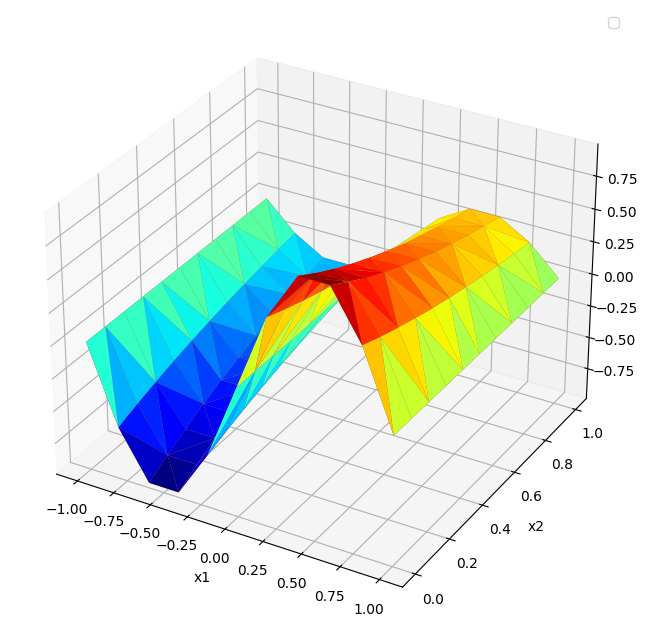

[2024-03-14 18:25:28.034622] initial (min) loss is 0.1771858036518097
[2024-03-14 18:29:57.073838] No improvement in 1000 steps
[2024-03-14 18:29:57.073838] Step = 35735 loss = 0.000000 normalized loss line= 0.532844x+-3.969116. There was 1 stop dings already.
[2024-03-14 18:31:01.497952] No improvement in 1000 steps
[2024-03-14 18:31:01.497952] Step = 44287 loss = 0.000001 normalized loss line= 0.062129x+3.271105. There was 2 stop dings already.
[2024-03-14 18:31:17.332900] No improvement in 1000 steps
[2024-03-14 18:31:17.332900] Step = 46389 loss = 0.000004 normalized loss line= 0.059741x+-0.742766. There was 3 stop dings already.
[2024-03-14 18:31:38.316736] No improvement in 1000 steps
[2024-03-14 18:31:38.316736] Step = 49173 loss = 0.000001 normalized loss line= -0.053890x+14.364637. There was 4 stop dings already.
[2024-03-14 18:32:46.222249] No improvement in 1000 steps
[2024-03-14 18:32:46.222249] Step = 58187 loss = 0.000001 normalized loss line= 0.056681x+7.409561. There wa

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


grid_res= 30
l2_norm =  0.00078577595
lu_f =  1.0854556753683224e-15


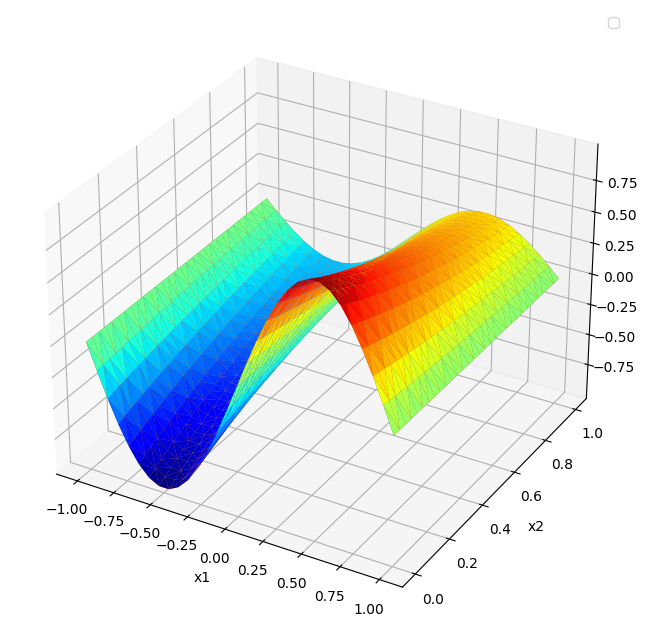

[2024-03-14 20:22:29.076705] initial (min) loss is 0.19234825670719147
[2024-03-14 20:26:04.484039] No improvement in 1000 steps
[2024-03-14 20:26:04.484039] Step = 28732 loss = 0.000012 normalized loss line= 0.014757x+0.225623. There was 1 stop dings already.
[2024-03-14 20:30:59.863106] No improvement in 1000 steps
[2024-03-14 20:30:59.863106] Step = 68147 loss = 0.000010 normalized loss line= -0.005675x+1.087848. There was 2 stop dings already.
[2024-03-14 20:31:34.891243] No improvement in 1000 steps
[2024-03-14 20:31:34.891243] Step = 72827 loss = 0.000000 normalized loss line= 0.048277x+17.222729. There was 3 stop dings already.
[2024-03-14 20:31:42.423784] No improvement in 1000 steps
[2024-03-14 20:31:42.423784] Step = 73833 loss = 0.000006 normalized loss line= 0.012185x+-0.075129. There was 4 stop dings already.
[2024-03-14 20:31:57.622417] No improvement in 1000 steps
[2024-03-14 20:31:57.622417] Step = 75861 loss = 0.000000 normalized loss line= -0.304119x+26.135109. There 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


grid_res= 50
l2_norm =  0.0009457856
lu_f =  1.4275137316118553e-15


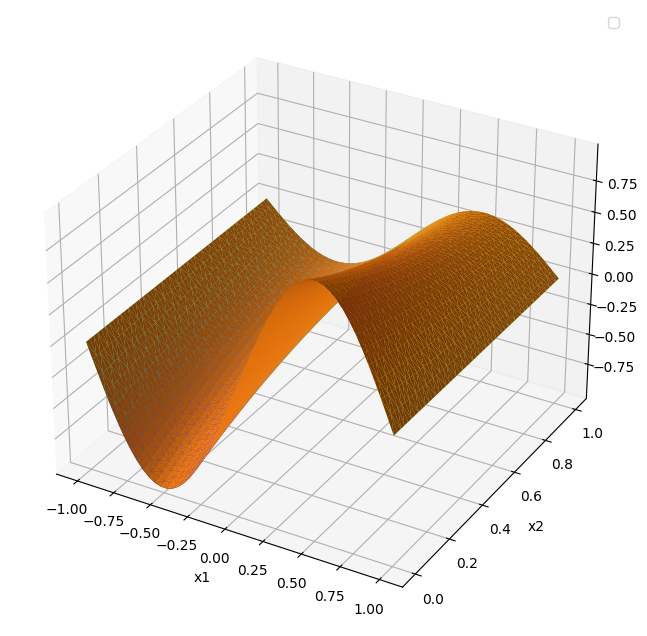

[2024-03-14 22:21:23.850419] initial (min) loss is 0.18217943608760834
[2024-03-14 22:28:21.454282] No improvement in 1000 steps
[2024-03-14 22:28:21.455325] Step = 54559 loss = 0.000028 normalized loss line= 0.002066x+0.302546. There was 1 stop dings already.
[2024-03-14 22:29:36.304683] No improvement in 1000 steps
[2024-03-14 22:29:36.305684] Step = 64329 loss = 0.000001 normalized loss line= 0.189419x+1.562824. There was 2 stop dings already.
[2024-03-14 22:31:12.020848] No improvement in 1000 steps
[2024-03-14 22:31:12.021350] Step = 76845 loss = 0.000002 normalized loss line= 0.150315x+-3.448141. There was 3 stop dings already.
[2024-03-14 22:31:20.333156] No improvement in 1000 steps
[2024-03-14 22:31:20.334156] Step = 77932 loss = 0.000008 normalized loss line= -0.014849x+1.622641. There was 4 stop dings already.
[2024-03-14 22:31:36.141572] No improvement in 1000 steps
[2024-03-14 22:31:36.141572] Step = 79999 loss = 0.000003 normalized loss line= 0.017191x+0.741212. There was

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


grid_res= 70
l2_norm =  0.0012253422
lu_f =  5.760647251474855e-16


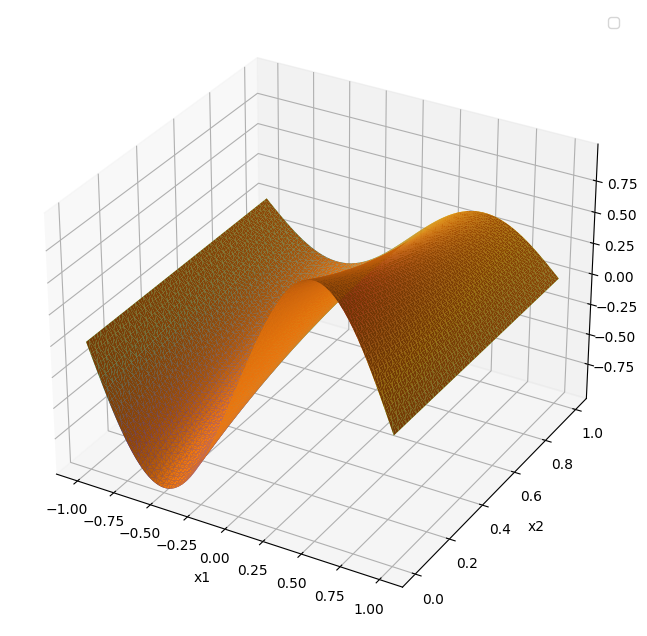

[2024-03-15 00:22:59.090836] initial (min) loss is 0.15319406986236572
[2024-03-15 00:32:47.601275] No improvement in 1000 steps
[2024-03-15 00:32:47.602275] Step = 73577 loss = 0.000001 normalized loss line= -0.015492x+4.707750. There was 1 stop dings already.
[2024-03-15 00:34:01.309298] No improvement in 1000 steps
[2024-03-15 00:34:01.309298] Step = 82820 loss = 0.000000 normalized loss line= -0.453396x+52.496816. There was 2 stop dings already.
[2024-03-15 00:34:15.870499] No improvement in 1000 steps
[2024-03-15 00:34:15.870499] Step = 84640 loss = 0.000000 normalized loss line= 0.945139x+-7.161496. There was 3 stop dings already.
[2024-03-15 00:34:31.597451] No improvement in 1000 steps
[2024-03-15 00:34:31.597451] Step = 86608 loss = 0.000002 normalized loss line= -0.019582x+5.747257. There was 4 stop dings already.
[2024-03-15 00:34:40.172715] No improvement in 1000 steps
[2024-03-15 00:34:40.173715] Step = 87681 loss = 0.000000 normalized loss line= 1.533722x+63.971494. There

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


grid_res= 90
l2_norm =  0.0017734139
lu_f =  5.30760850326234e-16


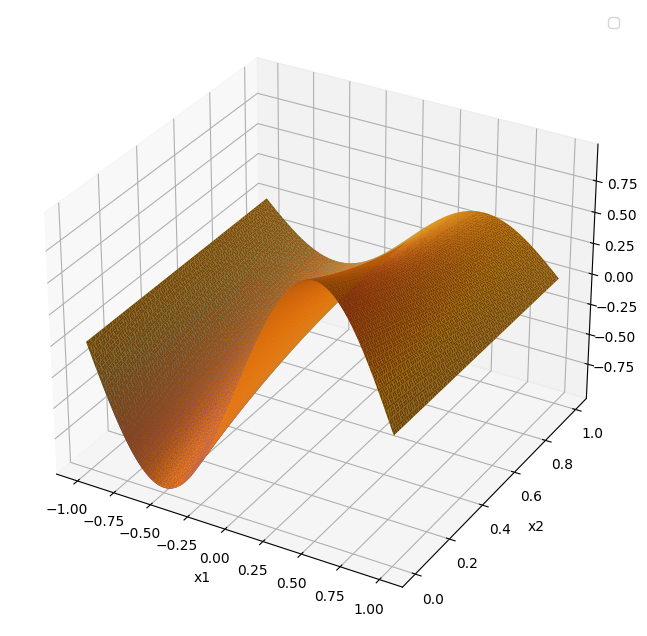

In [6]:
import pandas as pd

exp_dict_list=[]

nruns = 1

for N in grid_n:
    for _ in range(nruns):
        exp_dict_list.append(experiment_PSO(N))

exp_dict_list_flatten = [item for sublist in exp_dict_list for item in sublist]
df = pd.DataFrame(exp_dict_list_flatten)
df.to_csv('error_estimation_heat_PINN_PSO.csv')

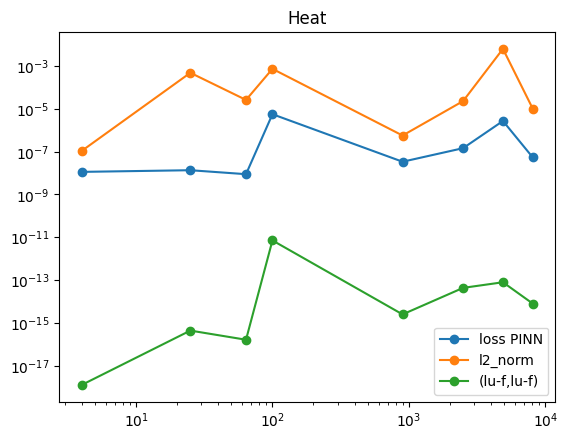

In [47]:
from ast import literal_eval

df_pinn = pd.read_csv('error_estimation_heat_PINN.csv')
y = []
for i in df_pinn['l2_loss']:
    y.append(literal_eval(i)[0])
# plt.plot(df['grid_res'], df_pinn['l2_norm']**2, '-*', label='l2_norm: PINN')
plt.plot(df_pinn['grid_res']**2, y, '-o', label='loss PINN')
plt.plot(df_pinn['grid_res']**2, df_pinn['l2_norm']**2, '-o', label='l2_norm')
plt.plot(df_pinn['grid_res']**2, df_pinn['lu_f'], '-o', label='(lu-f,lu-f)')
plt.yscale('log')
plt.xscale('log')
plt.title('Heat')
plt.legend()


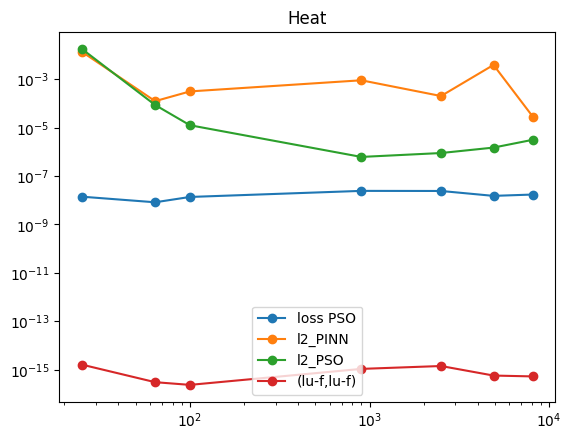

In [9]:
from ast import literal_eval

df_pinn = pd.read_csv('error_estimation_heat_PINN_PSO.csv')
y = []
for i in df_pinn['l2_loss']:
    y.append(literal_eval(i)[0])
# plt.plot(df['grid_res'], df_pinn['l2_norm']**2, '-*', label='l2_norm: PINN')
plt.plot(df_pinn['grid_res']**2, y, '-o', label='loss PSO')
plt.plot(df_pinn['grid_res']**2, df_pinn['l2_pinn']**2, '-o', label='l2_PINN')
plt.plot(df_pinn['grid_res']**2, df_pinn['l2_PSO']**2, '-o', label='l2_PSO')
plt.plot(df_pinn['grid_res']**2, df_pinn['lu_f'], '-o', label='(lu-f,lu-f)')
plt.yscale('log')
plt.xscale('log')
plt.title('Heat')
plt.legend()

Уравнение Пуассона с аналитическим решением u=tanh(x)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.optimize import least_squares

def func(x, a):
    return a / (x)


ydata_pinn = df_pinn['l2_norm']
ydata_lip = df_lip['l2_norm']

plt.plot(df_pinn['grid_res'], ydata_pinn**2, '-*', label='l2_norm: PINN')
plt.plot(df_lip['grid_res'], ydata_lip**2, '-*', label='l2_norm: LIPSH')
plt.xlabel('the number of training data, $m_r$')
plt.ylabel('error')
plt.yscale('log')
plt.xscale('log')
plt.ylim(1e-8, 100)
# plt.xlim(0, 1e4)

popt, pcov = curve_fit(func, df_pinn['grid_res'], ydata_pinn**2)
# def minim(a):
#     return func(xdata, a) - ydata
# result = least_squares(minim, 1)

plt.plot(df_pinn['grid_res'], func(df_pinn['grid_res'], *popt), '--', label=r"$C m_r^{-\frac{\alpha}{d}}$, C=0.75, $\alpha$=1, d=1")
plt.legend(fontsize="12")

## альфа - константа гёльедра.
## d - размерность входного пространства (R^d)
## C - подобранная константа методом curve_fit
popt

график из статьи https://arxiv.org/pdf/2004.01806.pdf

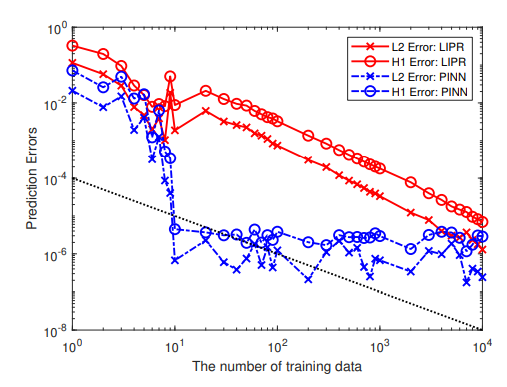

In [ ]:
df_pso = pd.read_csv('error_estimation_PINN_PSO.csv')

ydata_pso = df_pso['l2_PSO']
ydata_pinn = df_pso['l2_pinn']

plt.plot(df_pso['grid_res'], ydata_pso**2, '-*', label='l2_norm: PSO')
plt.plot(df_pso['grid_res'], ydata_pinn**2, '-o', label='l2_norm: PINN')

plt.xlabel('the number of training data, $m_r$')
plt.ylabel('error')
plt.yscale('log')
plt.xscale('log')
plt.legend(fontsize="12")
# plt.ylim(1e-8, 100)

In [ ]:
df_pso = pd.read_csv('error_estimation_mat.csv')

ydata_pso = df_pso['l2_mat']
ydata_pinn = df_pso['l2_pinn']

plt.plot(df_pso['grid_res'], ydata_pso**2, '-*', label='l2_norm: mat')
plt.plot(df_pso['grid_res'], ydata_pinn**2, '-o', label='l2_norm: autograd')

plt.xlabel('the number of training data, $m_r$')
plt.ylabel('error')
plt.yscale('log')
plt.xscale('log')
plt.legend(fontsize="12")
# plt.ylim(1e-8, 100)

In [ ]:
from ast import literal_eval
df = pd.read_csv('error_estimation_PINN_neurons.csv')

# ydata_pso = df_pso['l2_mat']
ydata_pinn = df['l2_norm']

# plt.plot(df_pso['grid_res'], ydata_pso**2, '-*', label='l2_norm: mat')
plt.plot(df['NN_res'], ydata_pinn**2, '-o', label='l2_norm: autograd')

plt.xlabel('the number of neurons, $N$')
plt.ylabel('error')
plt.yscale('log')
# plt.xscale('log')
plt.legend(fontsize="12")

In [ ]:
df = pd.read_csv('error_estimation_PINN_fourier.csv')
ydata_fourier = df['l2_norm']

df_pinn = pd.read_csv('error_estimation_PINN_1.csv')

plt.plot(df_pinn['grid_res'], df_pinn['l2_norm']**2, '-*', label='l2_norm: autograd')
plt.plot(df['grid_res'], ydata_fourier**2, '-o', label='l2_norm: autograd_fourier')
plt.xlabel('the number of training data, $m_r$')
plt.ylabel('error')
plt.yscale('log')
plt.xscale('log')
plt.legend(fontsize="12")


In [ ]:
df = pd.read_csv('error_estimation_PINN_lam.csv')
ydata_lam = df['l2_norm']

df_pinn = pd.read_csv('error_estimation_PINN_1.csv')

plt.plot(df_pinn['grid_res'], df_pinn['l2_norm']**2, '-*', label='l2_norm: autograd')
plt.plot(df['grid_res'], ydata_lam**2, '-o', label='l2_norm: autograd_lam')
plt.xlabel('the number of training data, $m_r$')
plt.ylabel('error')
plt.yscale('log')
plt.xscale('log')
plt.legend(fontsize="12")